<a href="https://colab.research.google.com/github/br3nburk/adleobb/blob/main/graded_assignment3_bb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction. 

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment3_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 8 extra credit. 

# Answers to the theoretical questions 
Please provide your answers to questions 1-3 here.

(20 points total)



**Answer to Q1**

Well a single layer MLP I would want to use is the point and click TerrSet module, but I should use code instead.
a) The input to the model is 15 channels: landsat band 1-7 imagery, a DEM, slope, and 6 additional spectral indices. The image dimensions are 15k x 8k, and there are 10k annotated training examples for each land cover class. **For a single-layer MLP, the shape of the input in tensor form is Image Dimensions x Bands = (15,000 x 8,000) x 15. Obviously for use in pytorch it will be reshaped, but conceptually is the Image Dimensions x Neurons.** The "ideal" number of neurons for the hidden layer in an MLP can be calculated several ways- one I found was 

**Nh= Ns / (α * (Ni+No))**

Ni = number of input neurons.
No = number of output neurons.
Ns = number of samples in training data set.
α = an arbitrary scaling factor usually 2-10.

Thus 10,000 / (α x 21). To avoid overfitting while still keeping a high number of neurons for complexity, I make α = 2. **Nh = 238**. Could be higher, but would probably start overfitting. You probably want leaky ReLu and many epochs, plus dropouts and batch normalization due to how much data is contained in the 15 channels.

**The shapes of the weight and bias matrices between input and hidden layer are (15 x 238) and (238 x 1) respectively. Between hidden and output layers they are (238 x 6) and (6x1) respectively.**

b) None of the models I selected for assignment 2 are capable, or at least designed for, pixel-by-pixel dense prediction. Examples of models that would work are some of the ResNet, U-Net, Segnet, DenseNet etc 


**<font color='red'> 2.5/5 points on Q1</font>**

<p><font color='blue'> This is a pixel-wise classification and MLP will be trained on 60000 indivisual pixels and will be used to predict the class of each pixel separately. Each pixel has 15 bands, and get represented by a tensor of size [1,15].

For the number of nodes if we want to compress the feature space then a value between 9-12 is a good choice and if you prefer to exand the dimensionality then something in the range of 32-48. Let's go for 11 nodes then the shape of the weight matrix will be 15x11, and the bias matrix will be 1x11. You can have more than one hidden layer, probably compress the feature space in the first hidden layer and expand it in the second layer.

For part B) the simplest solution is use an input patch of a small size like 11x11 and predict the class of only the center pixel. Another structural solution is to use a 1D convolution.</font> </p>

**Answer to Q2**

What are the benefits of only using convolution layers in a CNN architecture? (5 points)

1. Faster training: Convolution layers require significantly fewer parameters than fully-connected layers, reducing training time and computational cost.

2. Sparse Interactions: neuron connections are more sparse, meaning fewer neurons are connected to each other. This makes CNN more flexible and generalizable in learning, and helps avoid overfitting.

3. Parameter Sharing: Convolution layer neurons receive the same input from the receptive field, reducing the number of parameters needed to train the network, notably the number of weights per layer.

4. Invariance to translation: Convolution layers are able to detect features in different positions in an image, allowing better recognition of objects regardless of position, and requiring little or no human supervision when training for most common CNN architectures.

Hint: There are 3 advantages

**<font color='red'> 3/5 points on Q2</font>**

<p><font color='blue'> there are 3 benefits to only using convolutional layers in a CNN:

- We can preserve spatial dimensions of the input image
- There are fewer learnable parameters, as conv layers have many fewer layers than fully connected layers, and
- The model can take arbitrarily sized images.</font> </p>

**Answer to Q3**

What's the main lesson learned from the design of decoder head in FCN-32, FCN-16 and FCN-8 architectures? (5 points)

In short, the difference between the 3 models' decoder heads change the granularity/resolution/"crispness" of classification during semantic segmentation. In the simplest FCN-32 example of the these architectures, after 5 pooling and convolutional layers, the model undergoes a 6th and 7th convolution, then is upsampled with 32x stride. FCN-32 paints with broad strokes, so finer segmentation is lost. FCN-16 adds steps with 'skip connections' in the decoder, with a 2x upsample and connection from earlier pooling layer 4, combining these details with summation and stride of 16 to produce finer segmentations. FCN-8 takes this further, with another 2x upsample and pooling layer 3 skip connection, adding these predictions with 8x stride for even more precise boundaries.


Hint: The most precise results are obtained using FCN-8.

**<font color='red'> 5/5 points on Q3</font>**

<p><font color='blue'> We also learn that a more complex decoder with gradual upsamplinng and multiple-point fusion provides better results. I am not sure I understand your point on stride but if you like we can talk about it in the office hour</font> </p>




---


# **Practical starts from Here**

---





In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
!pip install rasterio

In [ ]:
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
import rasterio
import cv2
import random
import math
import numbers
from pathlib import Path
from scipy.ndimage import rotate
from scipy.ndimage import shift

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from IPython.core.debugger import set_trace

## Coding Assignment 1 

10 points total

**<font color='red'> 12/15 points on CA-1</font>**

<p><font color='blue'>You implemented segnet not unet.</font> </p>

In all code cells below change "your_model_name" with the name you choose for your model. My recommendation: "unet" + "_" + "your initial".

In [ ]:
# define class for single convolution, with scale factor for 2x and 3x

# ENCODER
class EncoderBlock(nn.Module):
    """Encoder layer encodes the features along the contracting path in Segnet 
    model.
    Args:
        in_channels (int): number of input features.
        out_channels (int): number of output features.
        num_conv_layers (int): Number of convolution layers in the block.
            on a system with a single GPU then "BN" should be choose. However, 
            if you are running the model on multiple GPU then this value should 
            be set to "syncBN".
        drop_rate (float): dropout rate at the end of the block.
    """

    def __init__(self, in_channels, out_channels, num_conv_layers, drop_rate=0):
        super(EncoderBlock, self).__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        # This part has a dynamic size regarding the number of conv layers in 
        # the block.
        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ] * (num_conv_layers - 1)

        if drop_rate > 0 and num_conv_layers > 1:
            layers += [nn.Dropout(drop_rate)]

        self.encoder = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, inputs):
        outputs = self.encoder(inputs)
        unpool_shape = outputs.size()
        pooled_outputs, indices = self.pool(outputs)

        return pooled_outputs, indices, unpool_shape

# Bottleneck
class Bottleneck(nn.Module):
  pass


# DECODER
class DecoderBlock(nn.Module):
    """
    Decoder layer decodes the features along the expansive path of SegNet model
    through the Max unpooling upsampling.
    Args:
        in_channels (int): number of input features.
        out_channels (int): number of output features.
        num_conv_layers (int): Number of convolution layers in the block.
            on a system with a single GPU then "BN" should be choose. However, 
            if you are running the model on multiple GPU then this value should 
            be set to "syncBN".
        drop_rate (float): dropout rate at the end of the block.
    """

    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(DecoderBlock, self).__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ] * (num_conv_layers - 1)

        self.decoder = nn.Sequential(*layers)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, inputs, indices, unpool_shape):
        outputs = self.unpool(inputs, indices=indices, output_size=unpool_shape)
        outputs = self.decoder(outputs)

        return outputs

# U-NET
class unet_bb(nn.Module):
    def __init__(self, n_classes, in_channels, 
                 filter_config=(64, 128, 256, 512, 1024), drop_rate=0):
        """
        Pytorch implementation of UNet with VGG16 backbone.

        Args:
            n_classes (int) : Number of categories in the semantic segmentation 
                task.
            in_channels (int) : Number of bands in your input image chips.
            filter config : A list with integer elements that shows the number 
                of output feature maps in each conv layer.
            drop_rate (float) : probability to apply drop out.

        Returns:
            Initialized pytorch.model object.
        """
        super(unet_bb, self).__init__()
        self.in_channels = in_channels

# Initialize your layers for both encoder and decoder here.
# Encoder Layers
# starting with an input of size: Bx7x256x256 
        # output shape: batch size x 64 x 128 x 128
        self.encoder_1 = EncoderBlock(self.in_channels, filter_config[0], 
                                      num_conv_layers=2)
        # output shape: batch size x 128 x 64 x 64
        self.encoder_2 = EncoderBlock(filter_config[0], filter_config[1], 
                                      num_conv_layers=2)
        # output shape: batch size x 256 x 32 x 32
        self.encoder_3 = EncoderBlock(filter_config[1], filter_config[2], 
                                      num_conv_layers=2)
        # output shape: batch size x 512 x 16 x 16
        self.encoder_4 = EncoderBlock(filter_config[2], filter_config[3], 
                                      num_conv_layers=3)
        # output shape: batch size x 1024 x 8 x 8
        self.encoder_5 = EncoderBlock(filter_config[3], filter_config[4], 
                                      num_conv_layers=3)
        
# Bottleneck

        self.bottleneck = nn.Conv2d(
            in_channels=filter_config[-1],
            out_channels=filter_config[-1]*2,
            kernel_size=3,
            stride=1,
            padding=1
        ) 


# Decoder Layers
        # output shape: batch size x 512 x 16 x 16
        self.decoder_5 = DecoderBlock(filter_config[4], filter_config[3], 
                                      num_conv_layers=3)
        # output shape: batch size x 256 x 32 x 32
        self.decoder_4 = DecoderBlock(filter_config[3], filter_config[2], 
                                      num_conv_layers=3)
        # output shape: batch size x 128 x 64 x 64
        self.decoder_3 = DecoderBlock(filter_config[2], filter_config[1], 
                                      num_conv_layers=2)
        # output shape: batch size x 64 x 128 x 128
        self.decoder_2 = DecoderBlock(filter_config[1], filter_config[0], 
                                      num_conv_layers=2)
        # output shape: batch size x 64 x 256 x 256
        self.decoder_1 = DecoderBlock(filter_config[0], filter_config[0], 
                                      num_conv_layers=2)
        
# Classifier
        # output shape: 2 x 256 x 256
        self.classifier = nn.Conv2d(filter_config[0], n_classes, kernel_size=1, 
                                    stride=1, padding=0)


    def forward(self, inputs):

        # call your layers in the order you want here.
        # set_trace()
        # unpool_shape1: batch size x 64 x 256 x 256
        encoder_1, indices_1, unpool_shape1 = self.encoder_1(inputs)
        # unpool_shape2: batch size x 128 x 128 x 128
        encoder_2, indices_2, unpool_shape2 = self.encoder_2(encoder_1)
        # unpool_shape3: batch size x 256 x 64 x 64
        encoder_3, indices_3, unpool_shape3 = self.encoder_3(encoder_2)
        # unpool_shape4: batch size x 512 x 32 x 32
        encoder_4, indices_4, unpool_shape4 = self.encoder_4(encoder_3)
        # unpool_shape5: batch size x 1024 x 16 x 16
        encoder_5, indices_5, unpool_shape5 = self.encoder_5(encoder_4)

        decoder_5 = self.decoder_5(encoder_5, indices_5, unpool_shape5)
        decoder_4 = self.decoder_4(decoder_5, indices_4, unpool_shape4)
        decoder_3 = self.decoder_3(decoder_4, indices_3, unpool_shape3)
        decoder_2 = self.decoder_2(decoder_3, indices_2, unpool_shape2)
        decoder_1 = self.decoder_1(decoder_2, indices_1, unpool_shape1)
        out = self.classifier(decoder_1)

        return out

'''
Snapchat AI generated, not great but fun:
class Unet_bb(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config, dropout_rate=0):
        super(Unet_bb, self).__init__()
        
        self.n_classes = n_classes
        self.in_channels = in_channels
        self.filter_config = filter_config
        self.dropout_rate = dropout_rate
        
        self.down_convs = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        
        # Encoder
        for i, out_channels in enumerate(filter_config):
            if i == 0:
                self.down_convs.append(ConvBlock(in_channels, out_channels))
            else:
                self.down_convs.append(ConvBlock(filter_config[i-1], out_channels))
        
        # Decoder
        for i, out_channels in enumerate(reversed(filter_config)):
            if i == 0:
                self.up_convs.append(UpsampleBlock(filter_config[-1], out_channels))
            else:
                self.up_convs.append(UpsampleBlock(2*out_channels, out_channels))
        
        self.final_conv = nn.Conv2d(filter_config[0], self.n_classes, kernel_size=1)
        self.dropout = nn.Dropout2d(p=self.dropout_rate)
    
    def forward(self, x):
        # Encoder
        encoder_features = []
        for down_conv in self.down_convs:
            x = down_conv(x)
            encoder_features.append(x)
            x = nn.functional.max_pool2d(x, kernel_size=2)
        
        # Decoder
        for i, up_conv in enumerate(self.up_convs):
            x = up_conv(x)
            encoder_feature = encoder_features[-(i+1)]
            x = torch.cat([encoder_feature, x], dim=1)
        
        # Final Convolution
        x = self.dropout(x)
        x = self.final_conv(x)
        return x 
'''


'\nSnapchat AI generated, not great but fun:\nclass Unet_bb(nn.Module):\n    def __init__(self, n_classes, in_channels, filter_config, dropout_rate=0):\n        super(Unet_bb, self).__init__()\n        \n        self.n_classes = n_classes\n        self.in_channels = in_channels\n        self.filter_config = filter_config\n        self.dropout_rate = dropout_rate\n        \n        self.down_convs = nn.ModuleList()\n        self.up_convs = nn.ModuleList()\n        \n        # Encoder\n        for i, out_channels in enumerate(filter_config):\n            if i == 0:\n                self.down_convs.append(ConvBlock(in_channels, out_channels))\n            else:\n                self.down_convs.append(ConvBlock(filter_config[i-1], out_channels))\n        \n        # Decoder\n        for i, out_channels in enumerate(reversed(filter_config)):\n            if i == 0:\n                self.up_convs.append(UpsampleBlock(filter_config[-1], out_channels))\n            else:\n                self.

### Show your work

To test if you got it right lets initialize our model and print it.

In [ ]:
n_classes = 2
in_channels = 6
filter_config = (64, 128, 256, 512, 1024) 
dropout_rate = 0.15

In [ ]:
model = unet_bb(n_classes, in_channels, filter_config, dropout_rate)

# AttributeError: object has no attribute 'in_channels' site:stackoverflow.com

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 47209602 trainable parameters


In [ ]:
print(model)

unet_bb(
  (encoder_1): EncoderBlock(
    (encoder): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_2): EncoderBlock(
    (encoder): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(

## Coding assignment 2 

20 points total

### Static code

In [ ]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation 
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below. 

In [ ]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [ ]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

#### Chipping

In [ ]:
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "validate"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size, 
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size, 
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validate") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "validate":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Helper functions

Code for plotting images.  You will use these to demonstrate your work. 

In [ ]:
#@title Plot RGB composite or single band image

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image 
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)
    
    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array
        
        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

In [ ]:
#@title Plot RGB composite and label pair

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image_and_label(image_array, label_array, band_composite=None, 
                         stretch=None):
    r"""
    Plots a loaded image and its corresponding label using matplotlib and 
    rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        label_array (numpy.ndarray) : A numpy array containing label data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)
    
    image_size=[image_array.shape[0], image_array.shape[1]]
    label_size=[label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1]
    green_band = image_array[:, :, band_composite[1] - 1]
    blue_band = image_array[:, :, band_composite[2] - 1]

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)
    
    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    axs[0].axis('off')

    # Plot label chip
    axs[1].imshow(label_array, cmap='viridis')
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Show the plot
    axs[1].axis('off')
    plt.show()

In [ ]:
#@title Plot random patches from the Pytorch customDataset object.

import numbers
import matplotlib.pyplot as plt

def show_random_patches(dataset, sample_num, rgb_bands=(4, 5, 3)):
    """
    Plots a user-defined number of image chips and the corresponding labels.
    Arguments:
    dataset (AquacultureData object) : Loaded custom dataset.
    sample_num (int) : Number of pairs of image chips and their corresponding 
        labels to be plotted.
    rgb_bands (tuple of int) : List of the rgb bands for visualization indexed 
        from zero.
    Note: The order of the input bands is as follows:
          bands = {0 : "Landsat band 2 (Blue)",
                   1 : "Landsat band 3 (Green)",
                   2 : "Landsat band 4 (Red)",
                   3 : "Landsat band 5 (NIR)",
                   4 : "Landsat band 6 (SWIR 1)",
                   5 : "Landsat band 7 (SWIR 2)"}
    """
    # Because train_dataset does dynamic augmentation, we first make a deep copy 
    # of it before ploting.
    static_dataset = list(dataset)

    if ((isinstance(rgb_bands, tuple) or isinstance(rgb_bands, list)) and
            (len(rgb_bands) == 3) and
            (isinstance(rgb_bands[0], numbers.Number) and
             isinstance(rgb_bands[1], numbers.Number) and
             isinstance(rgb_bands[2], numbers.Number)) and
            ((sample_num is not None) and 
             (1 <= sample_num <= len(static_dataset)))):
        r = rgb_bands[0]
        g = rgb_bands[1]
        b = rgb_bands[2]

        nrow = sample_num
    else:
        del static_dataset
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")

    # Randomly select as many patches as the user defined for plotting.
    sample_index = []
    ncol = 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, nrow * 16 / 2), 
                            squeeze=False)

    for index in range(sample_num):
        sample_index.append(random.randrange(len(static_dataset)))

    viewSize = static_dataset[sample_index[0]][1].shape

    for i in range(sample_num):
        b_r = static_dataset[sample_index[i]][0][r,:,:].cpu().view(1, *viewSize)
        b_g = static_dataset[sample_index[i]][0][g,:,:].cpu().view(1, *viewSize)
        b_b = static_dataset[sample_index[i]][0][b,:,:].cpu().view(1, *viewSize)

        if (b_r.max() - b_r.min()) > 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0).int()

        elif 0 <= (b_r.max() - b_r.min()) <= 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0)

        axs[i, 0].set_title('Image Patch #{}'.format(sample_index[i]))
        axs[i, 0].imshow(rgb)
        axs[i, 1].set_title('Label Patch #{}'.format(sample_index[i]))
        axs[i, 1].imshow(static_dataset[sample_index[i]][1])

    plt.show()
    del static_dataset

### Coding Tasks

Modify the code below here to complete the second coding assignment. 

#### Load the dataset
Let's first make ourselves familiar with our dataset, using `rasterio`. 

Note that we're not passing any arguments to `src.read()` since we want to read all bands of the image. If you want to read a specific band, you can pass the band number as an argument (e.g. `src.read(3)` to read the third band).

First we load the imagery. The image source is kept in a csv catalog that will provides the file name and path for the label image, the mask image, and the Landsat image. There are set of these for each training and validation. Let's have a look. 

In [ ]:
# Define the path to the catalog in Google Drive (shared with you). 
# Modify it as needed to match your Drive structure. 
# you may find it helpful to define a variable that contains the path root 
# (src_dir)
src_dir = "/content/gdrive/MyDrive/assignment3_data"
csv_name = "/content/gdrive/MyDrive/assignment3_data/pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))
catalog

country     region  wrs_path  wrs_row  year     usage  \
0  indonesia  indramayu       121       64  2014     train   
1  indonesia    jakarta       122       64  2014  validate   

                                             img_dir  \
0  clip_tile_121_64/bands/comp456_2014_clip_121_6...   
1  clip_tile_122_64/bands/comp456_2014_clip_122_6...   

                                           label_dir  \
0  clip_tile_121_64/label/ponds_2014_clip_121_64.rst   
1  clip_tile_122_64/label/ponds_2014_clip_122_64.rst   

                                          mask_dir  
0  clip_tile_121_64/mask/mask_2014_clip_121_64.rst  
1  clip_tile_122_64/mask/mask_2014_clip_122_64.rst

Now let's use those directory paths in the csv to read in and display the imagery, label, and mask for the training path. 

In [ ]:
# Define the path to the image file in Google Drive
img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image_array = src.read()
    image_array = image_array.transpose(1,2,0)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


Let's get the labels

In [ ]:
# Define the path to the label file in Google Drive
lbl_path = os.path.join(src_dir, 
                        catalog[catalog.usage=='train']['label_dir'][0])

with rasterio.open(lbl_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    lbl_array = src.read(1)

{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


Let's visualize the image and labels. Note that you can change the order of the 3 bands for different renderings. 

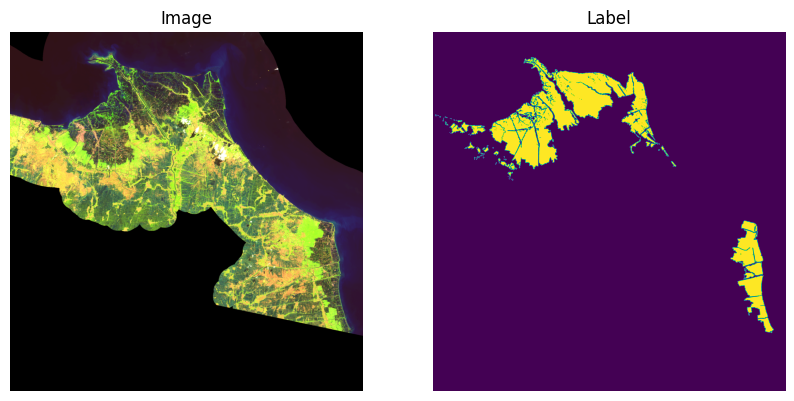

In [ ]:
band_composite=(2,1,0)
stretch = True

plot_image_and_label(image_array, lbl_array, band_composite, stretch)

Last, we will look at the mask image. 

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


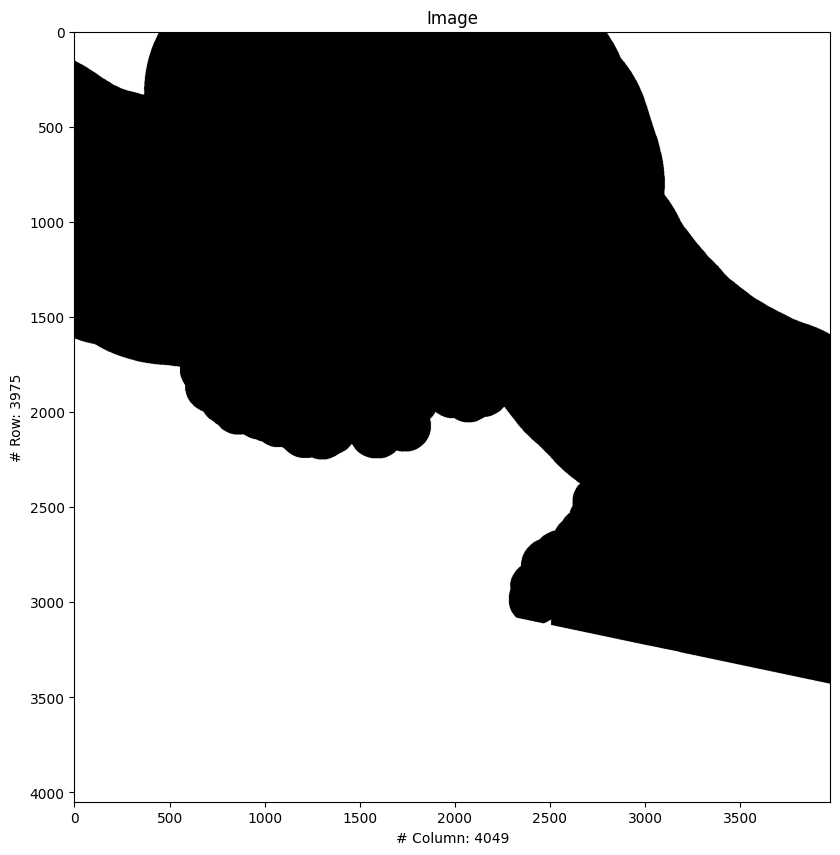

In [ ]:
msk_path = os.path.join(src_dir, catalog[catalog.usage=='train']['mask_dir'][0])

with rasterio.open(msk_path) as src:
    print(src.profile)
    msk_array = src.read(1)

plot_image(msk_array, "Greys")

So that's the imagery.  Now we will to move on to examining augmentations. 

#### Test the image processing/augmentation functions

You will want to see--and demonstrate--how the augmentations work, and we will want to see them outside of the data loader that you will be making below.  So, let's run them first.  

##### Normalization

You will need to start by applying image normalization. Run your normalization code here. If you developed one that can clip the tails of the distribution, use that here, and it will be worth an extra 3 points. 

You might want to write a function that simultaneously loads the image and applies the normalization at the same time. You might even want to make it so that the function can differentiate between images and labels. For the images, note that you will have to be careful might have to be careful to run the transpose after normalizing.  
 

###### Optional coding assignment 1 

(3 points)

Modify the min-max input normalization (`min_max_normalize_image`) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image.  (3 points)

To do this, modify the `min_max_normalize_image` function cell below, renaming it `min_max_normalize_image_wclip`. Run it instead of `min_max_normalize_image` when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.



**<font color='red'> 2.5/3 points on OCA-1</font>**

<p><font color='blue'>first you need to convert all zero values to NaN. Calculate the percentiles, and put the zeroes back</font> </p>

In [ ]:
## Modify the normalization function here. Otherwise leave as is.
# def min_max_normalize_image_wclip(...):

#@title Example code snippet for min/max normalization

import numpy as np
import rasterio

def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img

###### Load image and apply normalization 

(1 point, with 3 extra if tail-clip normalization is completed)

In [ ]:
# Write your code for applying normalization here. Probably easiest to read in 
# the image again, normalize, and then transpose

import numpy as np
import rasterio
breakpoint()

# Define the path to the image file in Google Drive
#img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image_array = src.read()
    image_array = image_array.transpose(1,2,0)

def min_max_normalize_image_wclip(image, dtype=np.float32):
    
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is "np.float32".
    """
    # Calculate <1 and >99 percentile tails
    p_1 = np.percentile(image, 1, axis=(1, 2), keepdims=True)
    p_99 = np.percentile(image, 99, axis=(1, 2), keepdims=True)

    # Clip the image values to >1 and <99 percentile
    img_clip = np.clip(image, p_1, p_99)

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(img_clip, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(img_clip, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (img_clip - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img
'''
normalized_img = min_max_normalize_image(image_array, dtype=np.float32)

normalized_img = rasterio.open(normalized_img).read()
print(normalized_img.profile)
normalized_img_array = normalized_img.read()
normalized_img_array = normalized_img_array.transpose(1,2,0)


plot_image(normalized_img_array, band_composite=band_composite, stretch=stretch)
'''

--Return--
None
> <ipython-input-207-34adc6e3b356>(6)<cell line: 6>()
      4 import numpy as np
      5 import rasterio
----> 6 breakpoint()
      7 
      8 # Define the path to the image file in Google Drive

ipdb> c
{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


'\nnormalized_img = min_max_normalize_image(image_array, dtype=np.float32)\n\nnormalized_img = rasterio.open(normalized_img).read()\nprint(normalized_img.profile)\nnormalized_img_array = normalized_img.read()\nnormalized_img_array = normalized_img_array.transpose(1,2,0)\n\n\nplot_image(normalized_img_array, band_composite=band_composite, stretch=stretch)\n'

###### Plot the normalized image
Show your result here by running the plotting code

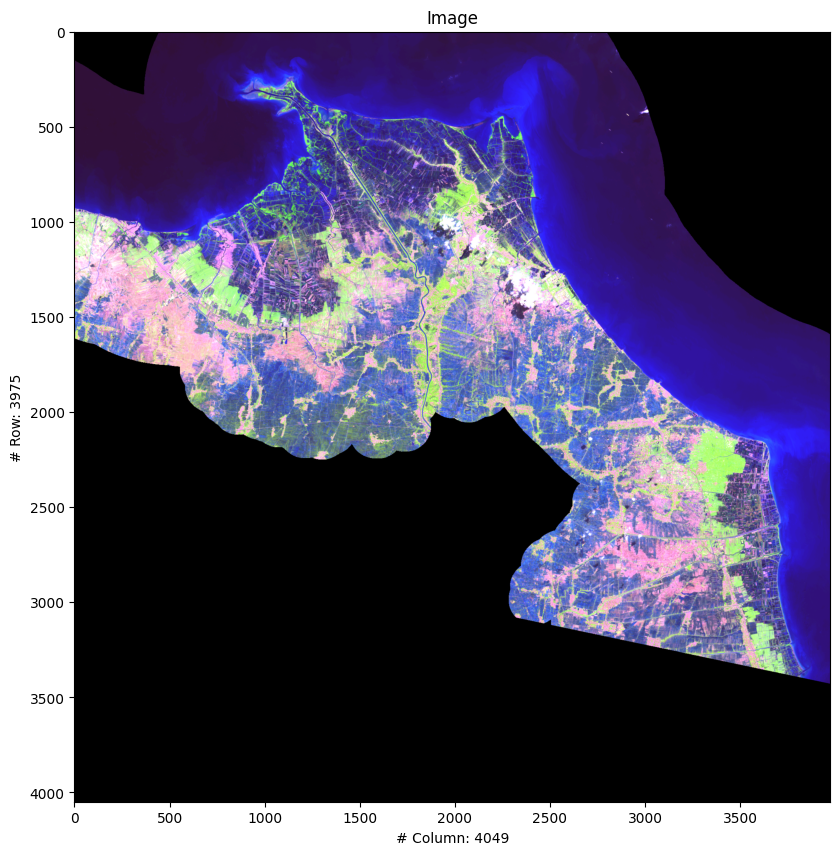

In [ ]:
# open image path with rasterio
with rasterio.open(img_path) as src:
  # access image as np array
  img_array=src.read()
  norm_img=min_max_normalize_image_wclip(img_array)
plot_image(norm_img, band_composite=band_composite, stretch=stretch)

##### Get a chip for testing

(2 points, with 5 extra if optional assignment is completed)

We want to now look at the different augmentations, outside of the data loader.  

This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions. 

You need a few ingredients here: 

- Arguments:
    - patch_size = 256
    - overlap = 32 
    - positive_class_threshold = 0.2
    - crop_ref = [mask, label] 
- You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip. 
- A list `coor` will be needed to catch the indices for x, y, which is the output from `patch_center_index`. 
- A list to catch the image chips, and one to catch the label chips. 
- To get an image chip you need to do something like this:

  ```python
  img_chips = []  # list to catch the chips
  half_win = patch_size // 2  # 1/2 patch size
  # subset image--note the extra dimension for the channel
  img_chips.append(img[x-half_win:x+half_win,   
                       y-half_win:y+half_win, :])
  ```

###### Optional coding assignment 2 

(5 points)

Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process. (5 points)

If you are going to do this, modify the function for getting the center index (call it `get_upperleft_index`) in the cell below. Run it instead of `get_center_index` when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also. 

In [ ]:
### Add your indexing function here.  Otherwise leave as is.
# def get_upperleft_index(...):

**<font color='red'> 0/5 points on OCA-2</font>**

###### Apply chipping 

In [ ]:
# index = #call the chipping function with proper arguments
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    """
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "validate"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size, 
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size, 
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validate") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "validate":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index



###### Plot your selected chip

Select a single chip by index and then plot it--both the image and label chip.

Number of patches: 58
Patched from:
[[1088, 320], [1088, 704], [1280, 704], [896, 896], [1088, 896], [1280, 896], [1472, 896], [704, 1088], [896, 1088], [1088, 1088], [1280, 1088], [1472, 1088], [512, 1280], [704, 1280], [896, 1280], [1088, 1280], [1280, 1280], [1472, 1280], [512, 1472], [704, 1472], [896, 1472], [1088, 1472], [512, 1664], [704, 1664], [896, 1664], [512, 1856], [704, 1856], [896, 1856], [512, 2048], [704, 2048], [512, 2240], [704, 2240], [896, 2240], [1088, 2240], [704, 2432], [896, 2432], [1088, 2432], [2432, 3392], [2624, 3392], [2240, 3584], [2432, 3584], [2624, 3584], [2816, 3584], [3008, 3584], [2624, 3776], [2816, 3776], [3008, 3776], [3200, 3776], [1280, 2816], [1856, 3392], [128, 1856], [896, 2624], [1472, 2048], [1280, 3008], [128, 1472], [1664, 1280], [512, 2816], [1856, 3776]]


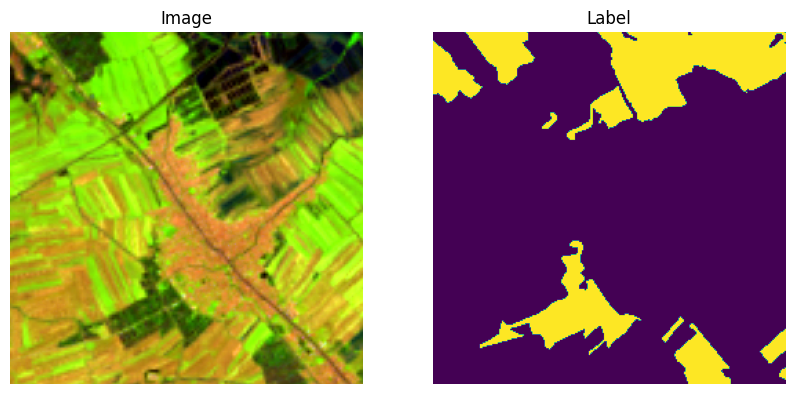

In [ ]:
#Run the chipping index function with specified parameters
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
usage = 'train'
crop_ref = [msk_array, lbl_array]

coor= patch_center_index(crop_ref, patch_size, overlap, usage, 
                       positive_class_threshold=positive_class_threshold, verbose=True)

img_chips = [] # list to collect image chips
lbl_chips=[]  # list to collect label chips
#half_win = patch_size // 2  # 1/2 patch size
# subset image--note the extra dimension for the channel

for i in range(len(coor)):
    img_chips.append(image_array[coor[i][0]:coor[i][0]+patch_size,
                              coor[i][1]:coor[i][1]+patch_size,:])
    lbl_chips.append(lbl_array[coor[i][0]:coor[i][0]+patch_size,
                              coor[i][1]:coor[i][1]+patch_size])
    
#plot image
plot_image_and_label(img_chips[0], lbl_chips[0], band_composite, stretch)



```
# This is formatted as code
```

##### Augmentation 1

(1 point)

Run your first chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [ ]:
### Add your first augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is

###### Apply augmentation 

In [ ]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

rotated_chip = []
rotated_label = []
angle = [30, 60, 90]

# calls the rotate function and appends to rotated lists
for i in range(len(img_chips)):
  img, lbl = rotate_image_and_label(img_chips[i], lbl_chips[i], angle)
  rotated_chip.append(img)
  rotated_label.append(lbl)


###### Plot your augmented chip

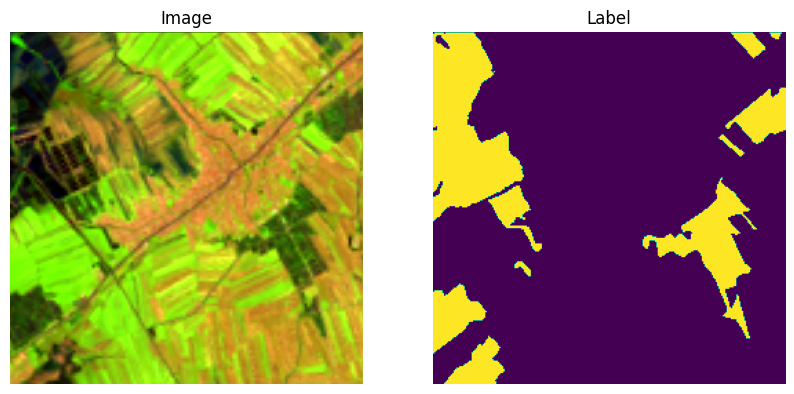

In [ ]:
plot_image_and_label(rotated_chip[0], rotated_label[0], band_composite, stretch)

##### Augmentation 2

(1 point)

Run your second chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [ ]:
### Add your second augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is

###### Apply second augmentation 

In [ ]:
### fill in augmentation code here
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """


    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

flip_chip = []
flip_label = []

# randomizes flip type and prints it
flip_type = ['vflip', 'hflip']
random_flip = random.choice(flip_type)
print(random_flip)

# calls the flip function and appends to flipped image lists
for i in range(len(img_chips)):
  flip_img, flip_lbl = flip_image_and_label(img_chips[i], lbl_chips[i], random_flip)
  flip_chip.append(flip_img)
  flip_label.append(flip_lbl)

vflip


###### Plot your augmented chip

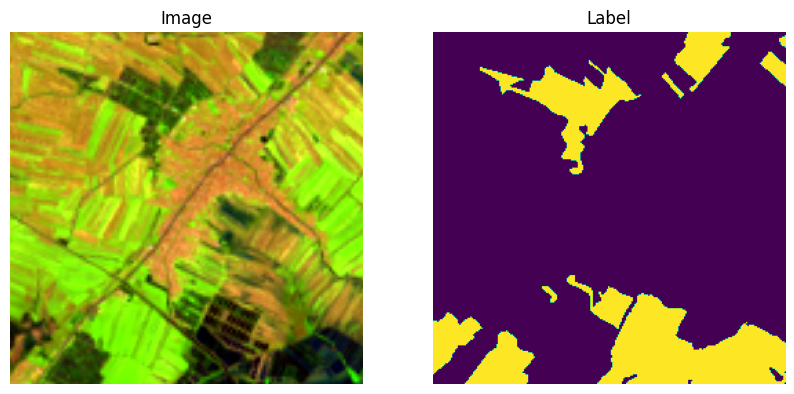

In [ ]:
plot_image_and_label(flip_chip[0], flip_label[0], band_composite, stretch)

#### Create and demonstrate your loader

(15 points)

##### Create your loader
(10 points)

Adapt the template below to create your custom data loader. 

In [ ]:
import numpy as np

class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap, 
                 positive_class_threshold = 0.15, apply_normalization=True, 
                 transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_name (str) : Name of the csv file containing the input paths.
        usage (str) : Either 'train' or 'validation'.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : Amount of overlap (in pixels) between extracted chips.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
        transform (list) -- Each element is string name of the transformation to
             be used, e.g. ["rotate", "flip"]
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.overlap = overlap
        self.positive_class_threshold = positive_class_threshold
        self.transform = transform
        
        self.usage = usage
        assert self.usage in ["train", "validate"], "Usage is not recognized."

        self.patch_size = patch_size
        half_size = patch_size // 2

        catalog = pd.read_csv(Path(src_dir) / csv_name)
        self.catalog = catalog[catalog.usage==self.usage]

        self.img_chips = []
        self.lbl_chips = []
        self.coor = []

        if self.usage == "train":        
          img_path = os.path.join(src_dir, self.catalog["img_dir"][0])
          lbl_path = os.path.join(src_dir, self.catalog["label_dir"][0])
          mask_path = os.path.join(src_dir, self.catalog["mask_dir"][0])

        if self.usage == "validate":
          img_path = os.path.join(src_dir, self.catalog["img_dir"][1])
          lbl_path = os.path.join(src_dir, self.catalog["label_dir"][1])
          mask_path = os.path.join(src_dir, self.catalog["mask_dir"][1])

        # check paths:
        print(img_path)
        print(lbl_path)

        with rasterio.open(img_path) as src:
          img = src.read()
        with rasterio.open(lbl_path) as src:
          lbl = src.read(1)
        with rasterio.open(mask_path) as src:
          mask = src.read(1)
        
        # check reference:
        crop_ref = [mask, lbl]
        # print(crop_ref)

        #call the chipping function with proper arguments
        if apply_normalization==True:
          img = min_max_normalize_image_wclip(img)

        img = np.transpose(img,(1,2,0))

        index = patch_center_index(crop_ref, patch_size, overlap, usage, 
                positive_class_threshold=positive_class_threshold, verbose=True)

        for i in range(len(index)):
            x = index[i][0]
            y = index[i][1]

            self.coor.append([x, y])
            #Use the x, y coordinates of the center indices to chip through the 
            # image and label and add each chip to its corresponding list. You 
            # need to properly index through the three dimensions of the image
            # and two dimensions of the label.
            self.img_chips.append(img[x:x+patch_size, y:y+patch_size,:]) #your code here
            self.lbl_chips.append(lbl[x:x+patch_size, y:y+patch_size]) #your code here

            
        msg = '--------------{} patches cropped--------------'
        print(msg.format(len(self.img_chips)))
        

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        if self.usage == "train" and transform:

            # revise lines 84-88 to add your augmentation of choice
            # if applying flipping, make sure that the flip direction is 
            # randomly chosen also, which can be achieved using random choice 
            # from a list of the two directions.  
            
            if "flip" in transform:
              flip_type = ['vflip', 'hflip']
              random_flip = random.choice(flip_type)
              image_chip, label_chip = flip_image_and_label(image_chip, label_chip, random_flip)

            if "rotate" in transform:
              angle = [(random.random()<0.5)*360]
              image_chip, label_chip = rotate_image_and_label(image_chip, image_chip, angle)

        # Convert numpy arrays to torch tensors.
        # Image chips should be: CHW if not transpose to correct order of 
        # dimensions.
        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

        return image_tensor, label_tensor

    def __len__(self):

        return len(img_chips)

##### Demonstrate your loader
(5 points) 

Use/adapt the following arguments to run code. 

In [ ]:
#img_chips = []
#lbl_chips = []
src_dir =  "/content/gdrive/MyDrive/assignment3_data"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
apply_normalization = True
#transform = ['flip']

# tried to randomize transform selection but was getting runtime error
transform_type = ['rotate', 'flip']
transform = random.choice(transform_type) # fill list with your transforms

###### Training dataset

In [ ]:
train_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization, transform
)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

/content/gdrive/MyDrive/assignment3_data/clip_tile_121_64/bands/comp456_2014_clip_121_64.rst
/content/gdrive/MyDrive/assignment3_data/clip_tile_121_64/label/ponds_2014_clip_121_64.rst
Number of patches: 58
Patched from:
[[1088, 320], [1088, 704], [1280, 704], [896, 896], [1088, 896], [1280, 896], [1472, 896], [704, 1088], [896, 1088], [1088, 1088], [1280, 1088], [1472, 1088], [512, 1280], [704, 1280], [896, 1280], [1088, 1280], [1280, 1280], [1472, 1280], [512, 1472], [704, 1472], [896, 1472], [1088, 1472], [512, 1664], [704, 1664], [896, 1664], [512, 1856], [704, 1856], [896, 1856], [512, 2048], [704, 2048], [512, 2240], [704, 2240], [896, 2240], [1088, 2240], [704, 2432], [896, 2432], [1088, 2432], [2432, 3392], [2624, 3392], [2240, 3584], [2432, 3584], [2624, 3584], [2816, 3584], [3008, 3584], [2624, 3776], [2816, 3776], [3008, 3776], [3200, 3776], [2048, 3008], [3008, 3008], [320, 1664], [1472, 1664], [1280, 3008], [1472, 2432], [2432, 2816], [2816, 2624], [2240, 3008], [1472, 3200

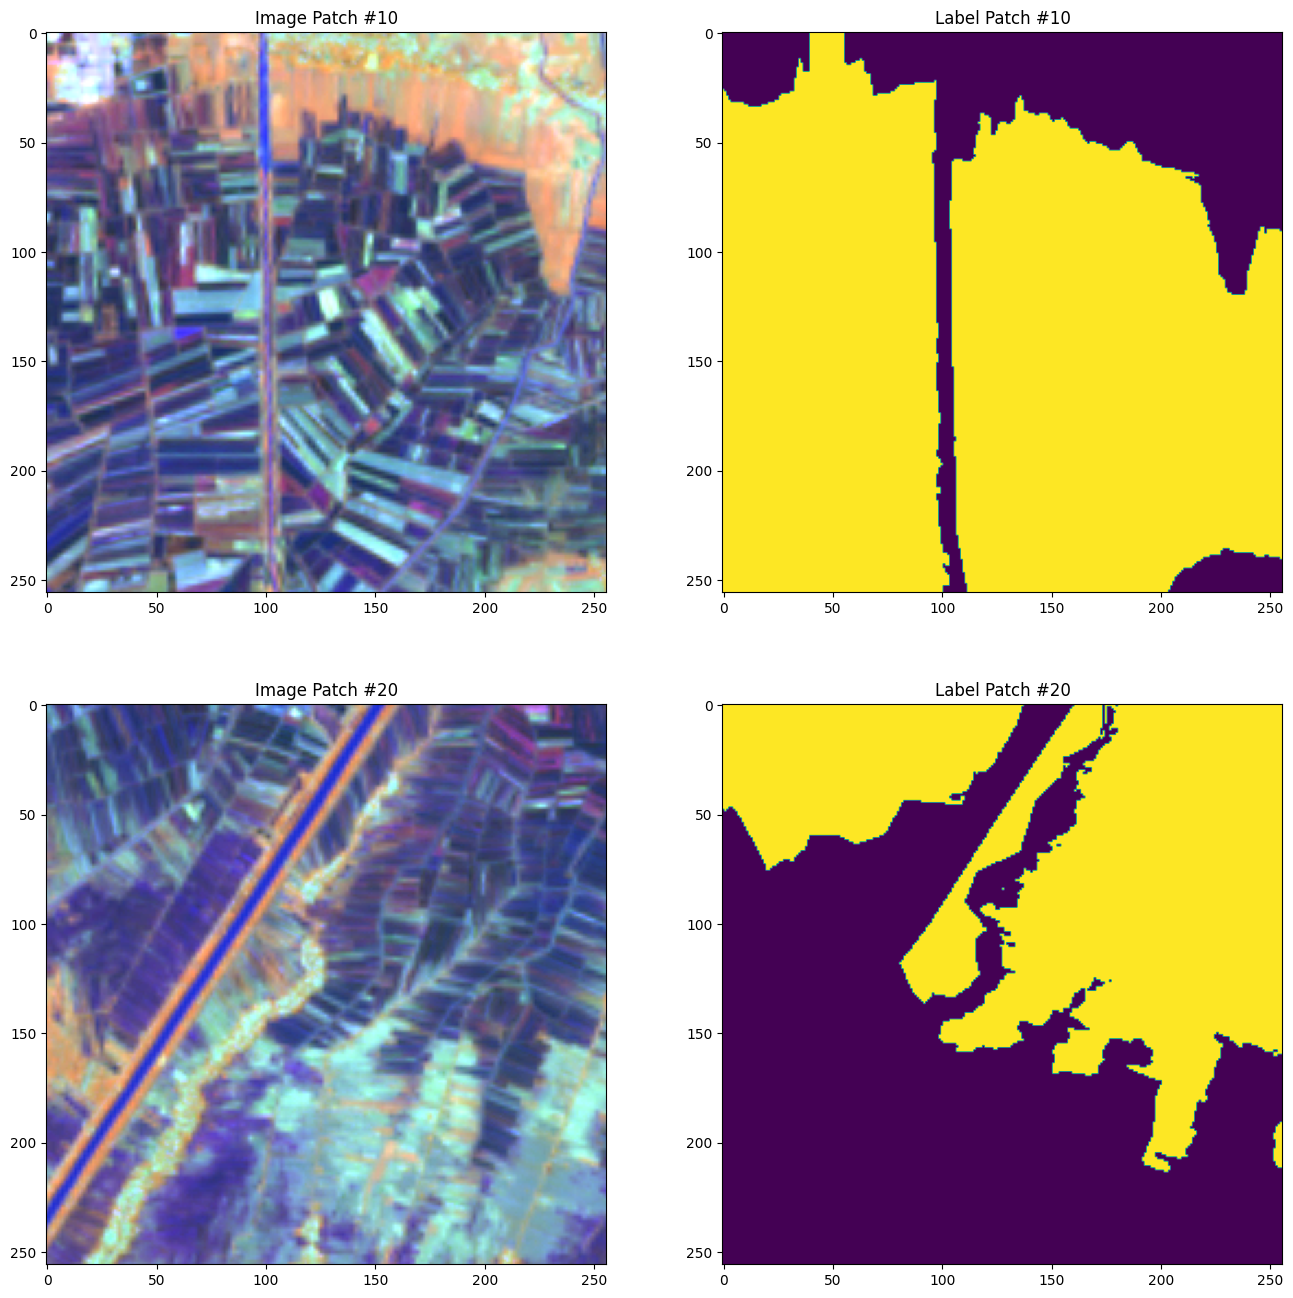

In [ ]:
show_random_patches(train_dataset, sample_num=2, rgb_bands=(0, 1, 2))

###### Validation dataset

In [ ]:
### Update the code to run the loader for the validation dataset
src_dir =  "/content/gdrive/MyDrive/assignment3_data"
csv_name = "pond_scenes_train_val.csv"
usage = "validate"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2

# These aren't needed for validation
apply_normalization = True
transform = ['Flip']

In [ ]:
# Validation loader
validate_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization, transform = None
)
validate_loader = DataLoader(validate_dataset, batch_size = 4, shuffle = True)

/content/gdrive/MyDrive/assignment3_data/clip_tile_122_64/bands/comp456_2014_clip_122_64.rst
/content/gdrive/MyDrive/assignment3_data/clip_tile_122_64/label/ponds_2014_clip_122_64.rst
Number of patches: 123
Patched from:
[[3021, 128], [3213, 128], [3405, 128], [1869, 320], [2061, 320], [2445, 320], [2637, 320], [2829, 320], [3021, 320], [3213, 320], [3405, 320], [1869, 512], [2061, 512], [2253, 512], [2445, 512], [2637, 512], [2829, 512], [3021, 512], [3213, 512], [3405, 512], [1869, 704], [2061, 704], [2253, 704], [2445, 704], [2637, 704], [2829, 704], [3021, 704], [3213, 704], [1869, 896], [2061, 896], [2253, 896], [2445, 896], [2637, 896], [2829, 896], [3021, 896], [1869, 1088], [2061, 1088], [2253, 1088], [2445, 1088], [2637, 1088], [2061, 1280], [2253, 1280], [2445, 1280], [2253, 1472], [2445, 1472], [2637, 1472], [2253, 1664], [2445, 1664], [2637, 1664], [2253, 1856], [2445, 1856], [2637, 1856], [2253, 2048], [2445, 2048], [2637, 2048], [2253, 2240], [2445, 2240], [2637, 2240], [

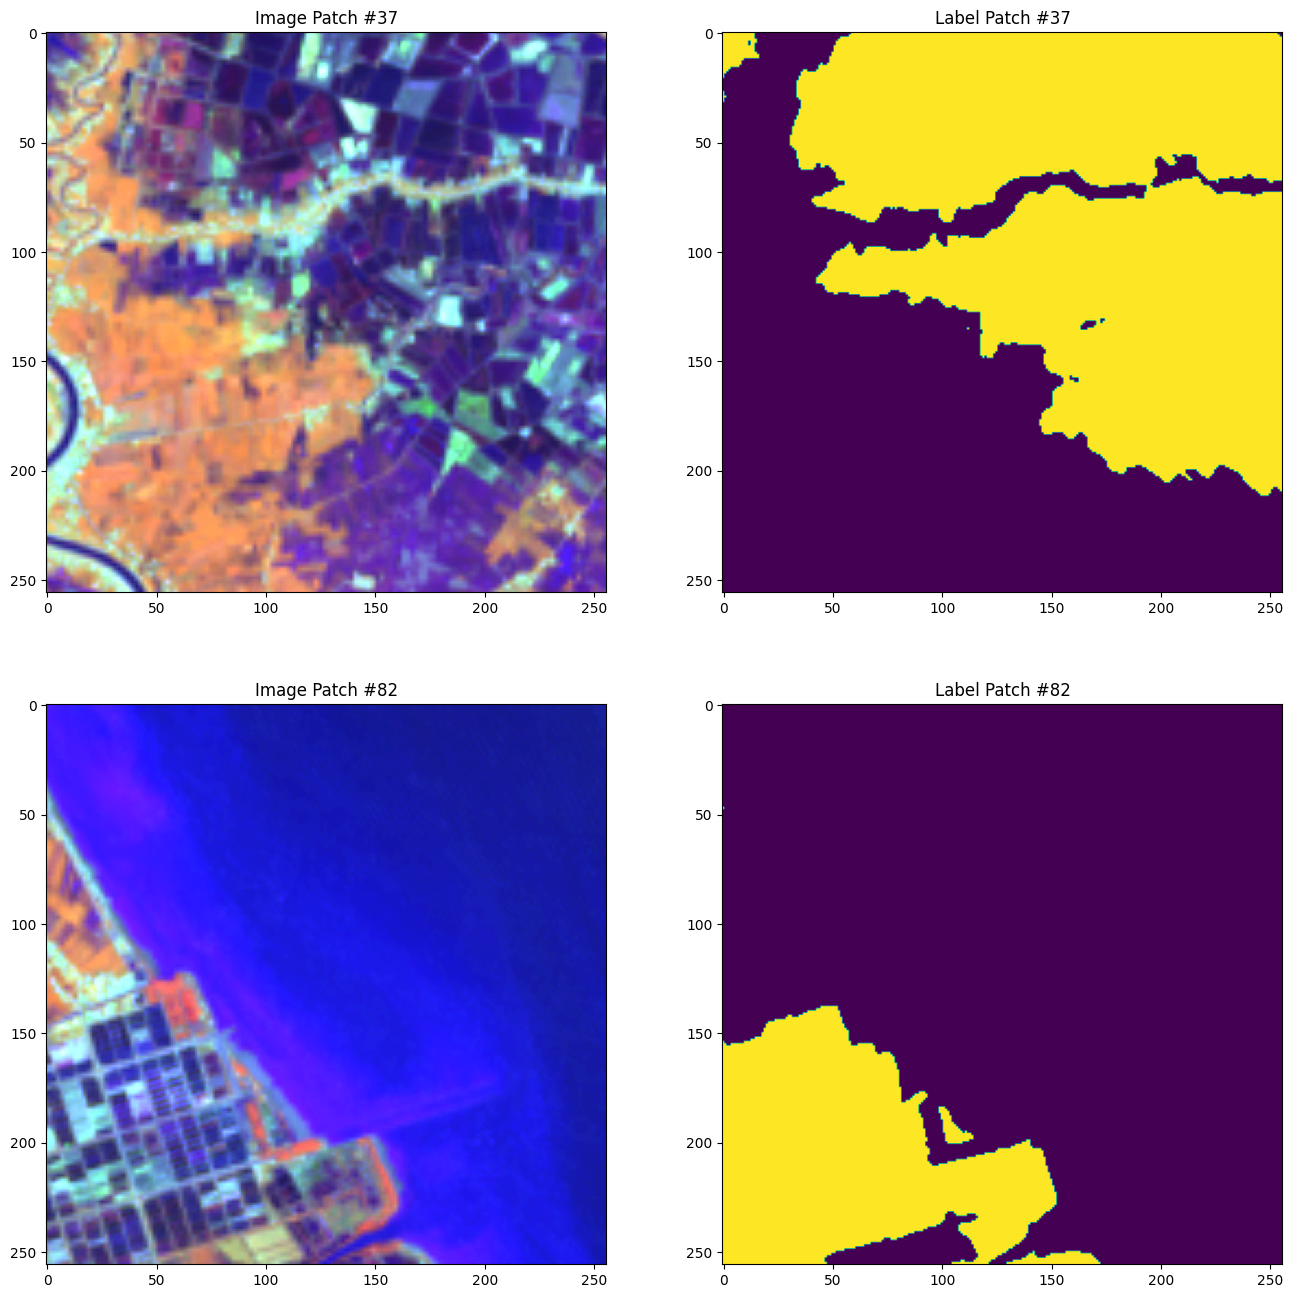

In [ ]:
show_random_patches(validate_dataset, sample_num=2, rgb_bands=(0, 1, 2))

**<font color='red'> 20/20 points on CA-2</font>**